## Auto Encoders with Keras

![alt text](https://cdn-images-1.medium.com/max/1600/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

Autoencoding" is a data compression and dimension reduction algorithm where the encoding and decoding functions are 
learned automatically from examples rather than engineered by a human. 

 Autoencoders are lossy, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.


# # Autoencoder with fully connected network for MNIST dataset

In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)


# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

display(autoencoder.summary())

encoder = Model(input_img, encoded)


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


None

In [2]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))



autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

(x_train, _), (x_test, _) = mnist.load_data()


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))



autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


11493376/11490434 [==============================] - 1s 0us/step
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.3567 - val_loss: 0.2707
Epoch 2/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.2631 - val_loss: 0.2522
Epoch 3/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.2427 - val_loss: 0.2309
Epoch 4/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.2227 - val_loss: 0.2123
Epoch 5/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.2067 - val_loss: 0.1992
Epoch 6/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.1959 - val_loss: 0.1902
Epoch 7/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.1881 - val_loss: 0.1834
Epoch 8/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.1817 - val_loss: 0.17

(32,)


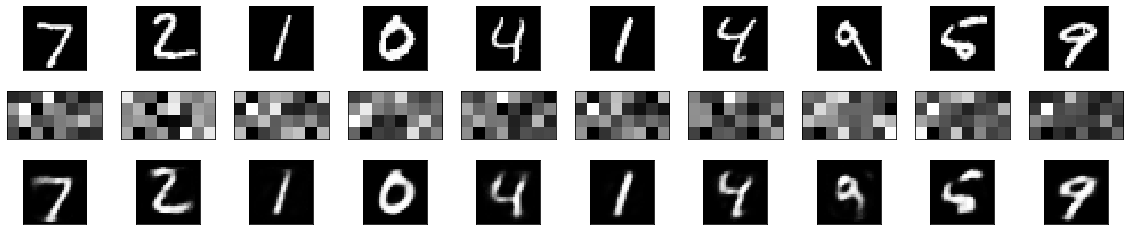

In [21]:

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

print(encoded_imgs[0].shape)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(4, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Sparse AutoEncoder

In [2]:
#Minimize the number of active neurons (?Regularization, preventing overfitting?)
# [1,0,0,0,1,0,0,1] ->> sum(abs(w))-   a=f(ax+b) || sum(abs(a))

# "0" [1,0,0,0,1,1,1,1]
# "1" [0,1,0,0,0,1,1,1] - last 3 neurons are useless for this special classification

#sparse "0" [1,0,0,0,0,0,0,1]
#sparse "1" [0,1,0,0,0,0,1,0]

# 784 inputs --- 1000
# 784 inputs --- 50 sparsity tells that 50 out of 1000 can be active at each input
#J(Y-Y_pr)+penalty_weight*sum(abs(a))

#activity regularizer is for the activations (output of the neuron)
#kernel_regularizer is for the weights

from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.regularizers import l2, l1
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import numpy as np

penalty_weight_act=0.000001
penalty_weight_ker=0.0001

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=l1(penalty_weight_act))(input_img) #, kernel_regularizer=l1(penalty_weight_ker)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)


# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

display(autoencoder.summary())

encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))



autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

(x_train, _), (x_test, _) = mnist.load_data()


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

mc = ModelCheckpoint('autoencoder.h5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
tb = TensorBoard(log_dir='./logs', histogram_freq=5, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

#load weights from the stored model
#autoencoder.load_weights('autoencoder.h5')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test), callbacks=[mc,es,tb])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_4 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


None

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.3828 - val_loss: 0.2896
Epoch 2/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.2825 - val_loss: 0.2733
Epoch 3/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.2642 - val_loss: 0.2536
Epoch 4/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.2454 - val_loss: 0.2359
Epoch 5/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.2306 - val_loss: 0.2235
Epoch 6/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.2203 - val_loss: 0.2146
Epoch 7/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.2125 - val_loss: 0.2075
Epoch 8/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.2061 - val_loss: 0.2018
Epoch 9/100
60000/60000 [=============================

(32,)


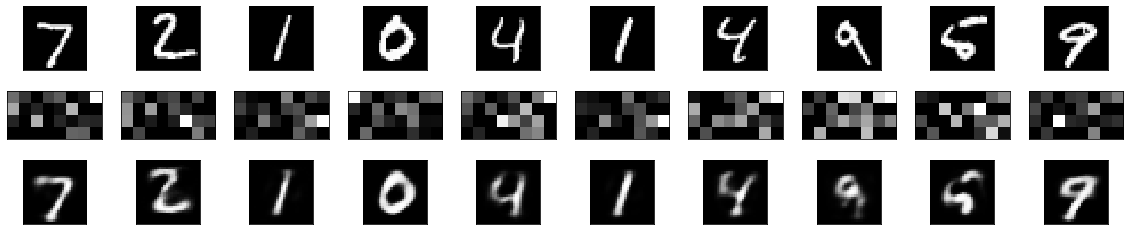

In [36]:

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

print(encoded_imgs[0].shape)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(4, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [51]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


--2019-06-07 13:24:00--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.22.145.207, 52.4.75.11, 54.174.228.92, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.22.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16648024 (16M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  15.88M  64.9MB/s    in 0.2s    

2019-06-07 13:24:01 (64.9 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [16648024/16648024]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [0]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [54]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://eb696448.ngrok.io


# Deep Autoencoder

# Convolutional Autoencoder

In [3]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
print(autoencoder.summary())
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

In [4]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  



autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 155us/step - loss: 0.2136 - val_loss: 0.1645
Epoch 2/50
60000/60000 [==============================] - 6s 106us/step - loss: 0.1559 - val_loss: 0.1421
Epoch 3/50
60000/60000 [==============================] - 6s 106us/step - loss: 0.1415 - val_loss: 0.1352
Epoch 4/50
60000/60000 [==============================] - 6s 107us/step - loss: 0.1342 - val_loss: 0.1390
Epoch 5/50
60000/60000 [==============================] - 6s 105us/step - loss: 0.1287 - val_loss: 0.1262
Epoch 6/50
60000/60000 [==============================] - 6s 105us/step - loss: 0.1245 - val_loss: 0.1226
Epoch 7/50
60000/60000 [==============================] - 6s 104us/step - loss: 0.1217 - val_loss: 0.1173
Epoch 8/50
60000/60000 [==============================] - 6s 104us/step - loss: 0.1194 - val_loss: 0.1181
Epoch 9/50
60000/60000 [==============================] - 6s 105us/step - loss: 0.1178 - val_loss: 0.1

KeyboardInterrupt: ignored

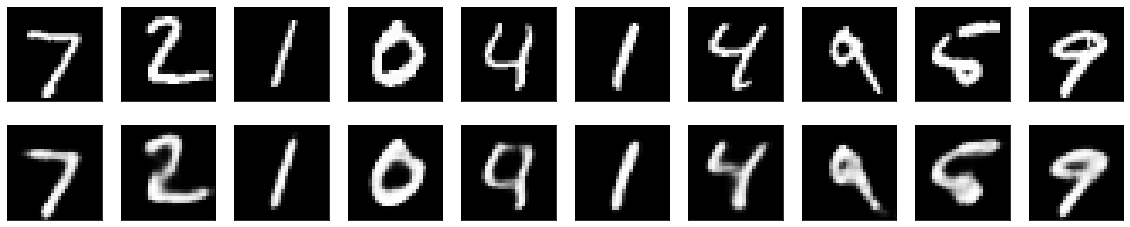

In [7]:
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Application to image denoising



In [0]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

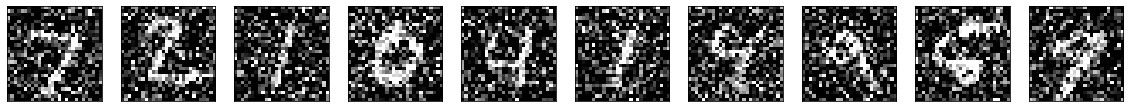

In [9]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [11]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 8s 134us/step - loss: 0.1720 - val_loss: 0.1276
Epoch 2/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.1186 - val_loss: 0.1118
Epoch 3/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.1115 - val_loss: 0.1073
Epoch 4/100
60000/60000 [==============================] - 7s 120us/step - loss: 0.1078 - val_loss: 0.1046
Epoch 5/100
60000/60000 [==============================] - 7s 120us/step - loss: 0.1051 - val_loss: 0.1035
Epoch 6/100
60000/60000 [==============================] - 7s 120us/step - loss: 0.1037 - val_loss: 0.1015
Epoch 7/100
60000/60000 [==============================] - 7s 120us/step - loss: 0.1028 - val_loss: 0.1028
Epoch 8/100
60000/60000 [==============================] - 7s 120us/step - loss: 0.1018 - val_loss: 0.1001
Epoch 9/100
60000/60000 [==============================] - 7s 120us/step - loss: 0.1012 - val_

KeyboardInterrupt: ignored

# Variational autoencoder (VAE)


In [0]:
import keras 
from keras.layers import Input, Dense, Lambda 
from keras.models import Model
from keras import backend as K

batch_size=32

original_dim=784
intermediate_dim=20

latent_dim =2 
encoder_input = Input(shape=(original_dim,))
x = Dense(intermediate_dim, activation='relu')(encoder_input)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)
h = Dense(intermediate_dim, activation='relu')(x)

z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [0]:

from keras.layers import Lambda
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=1)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [0]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [0]:
# end-to-end autoencoder
vae = Model(encoder_input, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(encoder_input, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [0]:
def vae_loss(x, x_decoded_mean):
    xent_loss = keras.losses.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.01 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [20]:

from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=100,
        batch_size=batch_size)

Epoch 1/100
60000/60000 [==============================] - 12s 197us/step - loss: 0.2694
Epoch 2/100
60000/60000 [==============================] - 11s 188us/step - loss: 0.2351
Epoch 3/100
60000/60000 [==============================] - 12s 192us/step - loss: 0.2302
Epoch 4/100
60000/60000 [==============================] - 11s 188us/step - loss: 0.2283
Epoch 5/100
60000/60000 [==============================] - 11s 189us/step - loss: 0.2271
Epoch 6/100
60000/60000 [==============================] - 12s 195us/step - loss: 0.2261
Epoch 7/100
60000/60000 [==============================] - 11s 188us/step - loss: 0.2254
Epoch 8/100
60000/60000 [==============================] - 11s 188us/step - loss: 0.2247
Epoch 9/100
60000/60000 [==============================] - 11s 188us/step - loss: 0.2241
Epoch 10/100
60000/60000 [==============================] - 11s 188us/step - loss: 0.2236
Epoch 11/100
60000/60000 [==============================] - 11s 187us/step - loss: 0.2231
Epoch 12/100
60000/

KeyboardInterrupt: ignored

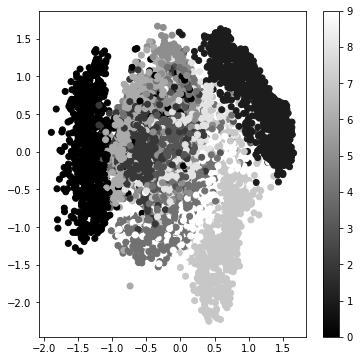

In [21]:
import matplotlib.pyplot as plt

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

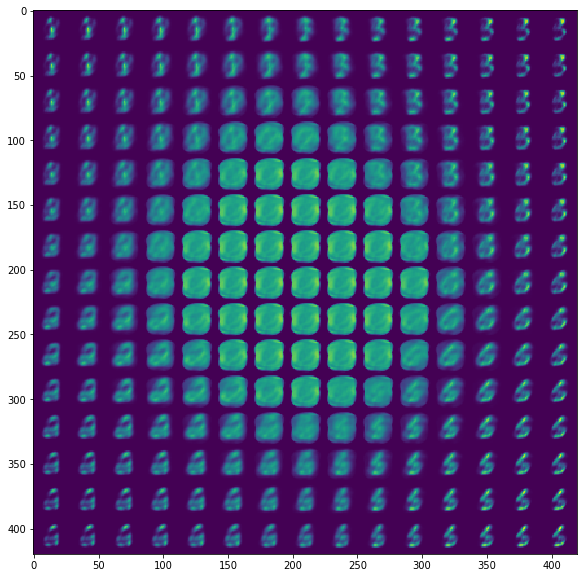

In [0]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

![alt text](https://blog.keras.io/img/ae/vae_digits_manifold.png)